# Setup

This project requires Python 3.7 or above:

In [325]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [326]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [327]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [328]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [329]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons
## The Perceptron

In [330]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [331]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [332]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

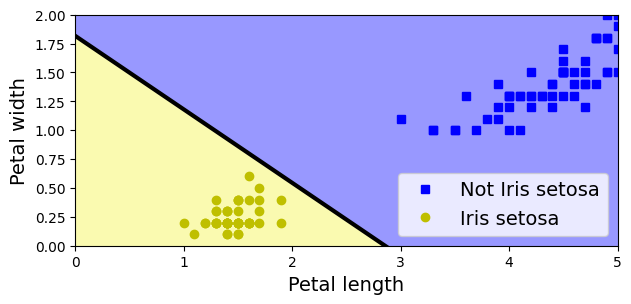

In [333]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Activation functions**

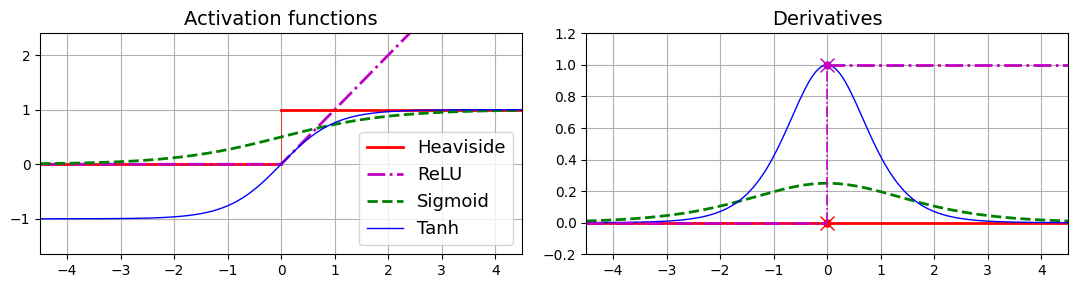

In [334]:


from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## Regression MLPs

In [335]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

/opt/anaconda3/envs/Alex_venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [336]:
rmse

0.5053326657968762

## Classification MLPs

In [337]:

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [338]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [339]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [340]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [341]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

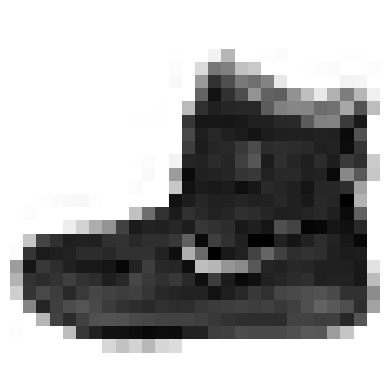

In [342]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [343]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [344]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [345]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

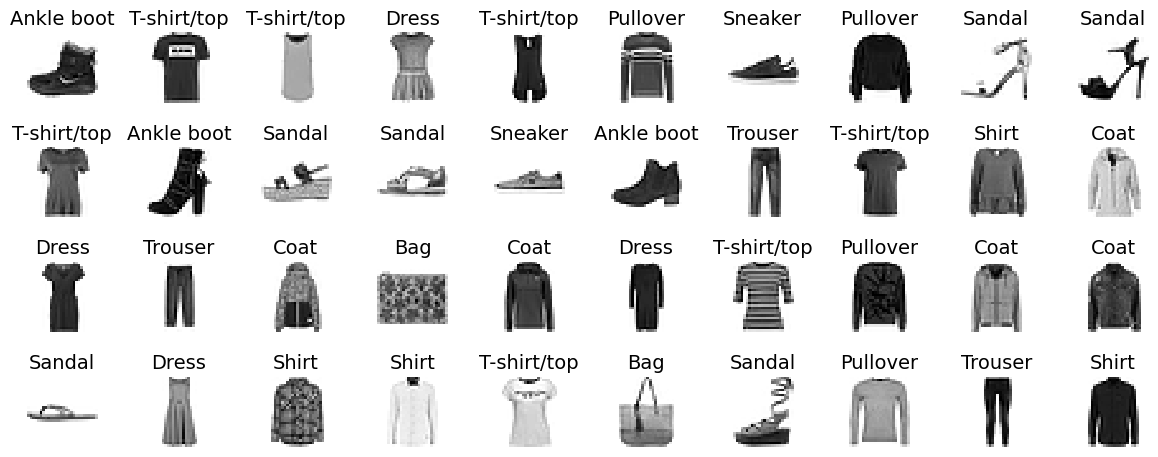

In [346]:


n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### Creating the model using the Sequential API

In [347]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

/opt/anaconda3/envs/Alex_venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [348]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/opt/anaconda3/envs/Alex_venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [349]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [350]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [351]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [352]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [353]:
model.get_layer('dense') is hidden1

True

In [354]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.01271798, -0.06406421, -0.0177309 , ...,  0.05607559,
         0.04628741,  0.05710737],
       [-0.06415538, -0.0294646 , -0.020152  , ..., -0.00733262,
        -0.03142578,  0.04209635],
       [ 0.0582456 ,  0.04077954, -0.05909455, ..., -0.00040125,
        -0.05107537, -0.04240184],
       ...,
       [-0.02971094, -0.03563175, -0.05819513, ..., -0.03641315,
         0.03103915,  0.05646457],
       [ 0.0012235 , -0.06402534,  0.05549225, ...,  0.0145459 ,
         0.0189571 ,  0.02113084],
       [-0.04087187,  0.04092439,  0.0354948 , ..., -0.0680225 ,
         0.0345508 , -0.02668032]], dtype=float32)

In [355]:
weights.shape

(784, 300)

In [356]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [357]:
biases.shape

(300,)

### Compiling the model

In [358]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

In [359]:
# extra code – this cell is equivalent to the previous cell
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [360]:
# extra code – shows how to convert class ids to one-hot vectors
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Note: it's important to set `num_classes` when the number of classes is greater than the maximum class id in the sample.

In [361]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

### Training and evaluating the model

In [362]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 840us/step - loss: 1.0002 - sparse_categorical_accuracy: 0.6868 - val_loss: 0.5052 - val_sparse_categorical_accuracy: 0.8270
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 890us/step - loss: 0.5065 - sparse_categorical_accuracy: 0.8257 - val_loss: 0.4549 - val_sparse_categorical_accuracy: 0.8370
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - loss: 0.4535 - sparse_categorical_accuracy: 0.8434 - val_loss: 0.4324 - val_sparse_categorical_accuracy: 0.8456
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - loss: 0.4236 - sparse_categorical_accuracy: 0.8537 - val_loss: 0.4169 - val_sparse_categorical_accuracy: 0.8474
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - loss: 0.4021 - sparse_categorical_accuracy: 0.8608 - val_loss: 0.4047 - val_sparse_categorical_accuracy: 0.8520
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - loss: 0.3849 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.3959 - val_sparse_categoric

In [363]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

In [364]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


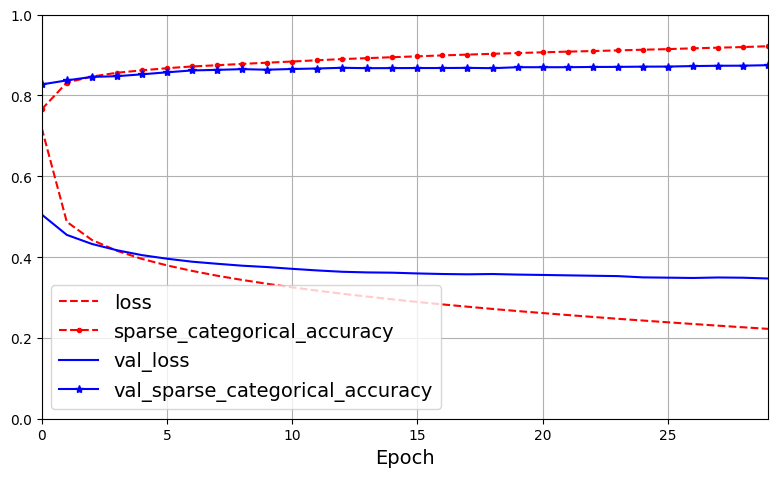

In [365]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

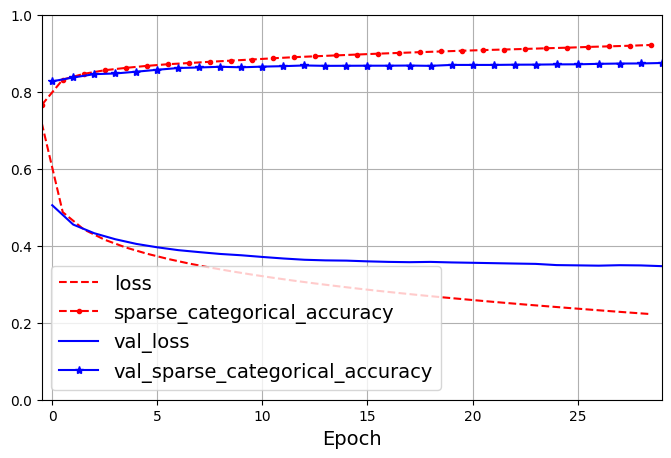

In [366]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [367]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 0.3628 - sparse_categorical_accuracy: 0.8722


[0.3629968762397766, 0.8740000128746033]

### Using the model to make predictions

In [368]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.27, 0.  , 0.01, 0.  , 0.72],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [369]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [370]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [371]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

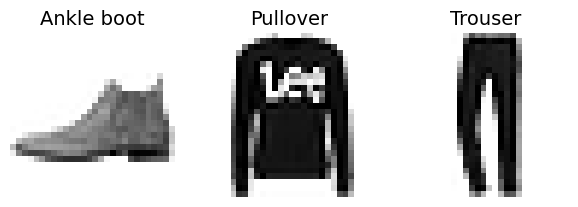

In [372]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Building a Regression MLP Using the Sequential API

In [373]:
# extra code – load and split the California housing dataset, like earlier
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [374]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20


/opt/anaconda3/envs/Alex_venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - RootMeanSquaredError: 1.1540 - loss: 1.4042 - val_RootMeanSquaredError: 0.6407 - val_loss: 0.4105
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - RootMeanSquaredError: 0.6374 - loss: 0.4066 - val_RootMeanSquaredError: 0.6222 - val_loss: 0.3871
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - RootMeanSquaredError: 0.6080 - loss: 0.3698 - val_RootMeanSquaredError: 0.9015 - val_loss: 0.8128
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - RootMeanSquaredError: 0.5964 - loss: 0.3559 - val_RootMeanSquaredError: 0.5990 - val_loss: 0.3588
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - RootMeanSquaredError: 0.5848 - loss: 0.3422 - val_RootMeanSquaredError: 1.0782 - val_loss: 1.1626
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - RootMeanSquaredError: 0.5744 - loss: 0.3301 - val_RootMeanSquaredError: 1.2575 - val_loss: 1.5813
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - RootMeanSquaredError: 0.5682 - 

In [375]:
rmse_test

0.5376605987548828

In [376]:
y_pred

array([[0.5383887],
       [1.0419247],
       [5.0484977]], dtype=float32)

## Building Complex Models Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [377]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [378]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [379]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 8)         │         17 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

In [380]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 587us/step - RootMeanSquaredError: 1.4237 - loss: 2.1396 - val_RootMeanSquaredError: 1.0951 - val_loss: 1.1992
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - RootMeanSquaredError: 0.7004 - loss: 0.4917 - val_RootMeanSquaredError: 1.4078 - val_loss: 1.9818
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - RootMeanSquaredError: 0.6417 - loss: 0.4122 - val_RootMeanSquaredError: 1.5762 - val_loss: 2.4845
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - RootMeanSquaredError: 0.6265 - loss: 0.3927 - val_RootMeanSquaredError: 2.1879 - val_loss: 4.7871
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - RootMeanSquaredError: 0.6199 - loss: 0.3845 - val_RootMeanSquaredError: 1.9583 - val_loss: 3.8350
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - RootMeanSquaredError: 0.6112 - loss: 0.3737 - val_RootMeanSquaredError: 1.2871 - val_loss: 1.6567
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - RootMeanSquaredError

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [381]:
tf.random.set_seed(42)  # extra code

In [382]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [383]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - RootMeanSquaredError: 1.3984 - loss: 2.0487 - val_RootMeanSquaredError: 0.7057 - val_loss: 0.4980
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - RootMeanSquaredError: 0.7123 - loss: 0.5079 - val_RootMeanSquaredError: 0.6742 - val_loss: 0.4546
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - RootMeanSquaredError: 0.6605 - loss: 0.4365 - val_RootMeanSquaredError: 0.6628 - val_loss: 0.4393
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - RootMeanSquaredError: 0.6406 - loss: 0.4105 - val_RootMeanSquaredError: 0.6054 - val_loss: 0.3665
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - RootMeanSquaredError: 0.6289 - loss: 0.3957 - val_RootMeanSquaredError: 0.7390 - val_loss: 0.5462
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - RootMeanSquaredError: 0.6207 - loss: 0.3855 - val_RootMeanSquaredError: 0.5881 - val_loss: 0.3459
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - RootMeanSquaredError

Adding an auxiliary output for regularization:

In [384]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [385]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [386]:

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
"""
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError"])
"""
model.compile(
    loss=("mse", "mse"), 
    loss_weights=(0.9, 0.1), 
    optimizer=optimizer,
    metrics={"dense_2": "RootMeanSquaredError", "dense_3": "RootMeanSquaredError"}
)

In [387]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    [X_train_wide, X_train_deep], [y_train, y_train], epochs=20,
    validation_data=([X_valid_wide, X_valid_deep], [y_valid, y_valid])
)
    


Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - dense_2_RootMeanSquaredError: 1.4626 - dense_3_RootMeanSquaredError: 1.8559 - loss: 2.3595 - val_dense_2_RootMeanSquaredError: 0.7824 - val_dense_3_RootMeanSquaredError: 1.3424 - val_loss: 0.7311
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - dense_2_RootMeanSquaredError: 0.7337 - dense_3_RootMeanSquaredError: 0.9717 - loss: 0.5801 - val_dense_2_RootMeanSquaredError: 0.6449 - val_dense_3_RootMeanSquaredError: 0.8424 - val_loss: 0.4452
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - dense_2_RootMeanSquaredError: 0.6667 - dense_3_RootMeanSquaredError: 0.8212 - loss: 0.4678 - val_dense_2_RootMeanSquaredError: 0.7585 - val_dense_3_RootMeanSquaredError: 0.8388 - val_loss: 0.5881
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - dense_2_RootMeanSquaredError: 0.6498 - dense_3_RootMeanSquaredError: 0.7676 - loss: 0.4392 - val_dense_2_RootMeanSquaredError: 0.6113 - val_dense_3_RootMeanSquaredError: 0.8045 - val_loss:

In [398]:

eval_results = model.evaluate([X_test_wide, X_test_deep], (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse = eval_results





162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 0.3579 - root_mean_squared_error: 0.5919 - root_mean_squared_error_1: 0.6519


In [389]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [390]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


## Using the Subclassing API to Build Dynamic Models

In [460]:

@keras.utils.register_keras_serializable()
#class WideAndDeepModel(keras.Model):
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

In [461]:


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=[
        [tf.keras.metrics.RootMeanSquaredError()],
        [tf.keras.metrics.RootMeanSquaredError()]
        
    ])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
#print(len(eval_results))
#print(eval_results)

weighted_sum_of_losses, main_loss, aux_loss, main_rmse = eval_results



Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - loss: 3.7712 - root_mean_squared_error: 1.9092 - root_mean_squared_error_1: 1.8584 - val_loss: 3.2332 - val_root_mean_squared_error: 1.2933 - val_root_mean_squared_error_1: 4.1568
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 0.7244 - root_mean_squared_error: 0.8299 - root_mean_squared_error_1: 1.0169 - val_loss: 1.1661 - val_root_mean_squared_error: 0.7786 - val_root_mean_squared_error_1: 2.4909
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 0.5605 - root_mean_squared_error: 0.7357 - root_mean_squared_error_1: 0.8551 - val_loss: 0.6793 - val_root_mean_squared_error: 0.6780 - val_root_mean_squared_error_1: 1.6296
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 0.5019 - root_mean_squared_error: 0.6969 - root_mean_squared_error_1: 0.8028 - val_loss: 0.6735 - val_root_mean_squared_error: 0.7982 - val_root_mean_squared_error_1: 1.0007
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - 

## Saving and Restoring a Model

In [462]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [464]:
#model.save("my_keras_model", save_format="tf")
#model.save("my_keras_model")  # Save without specifying an extension
#model.save("my_keras_model.h5") #save as Legacy format
#from tensorflow import keras

#@keras.utils.register_keras_serializable()
#class WideAndDeepModel(keras.Model):
    
model.save('my_keras_model.keras')




In [465]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model.keras").glob("**/*")):
    print(path)

In [466]:
import os

model_file = 'my_keras_model.h5'
if os.path.exists(model_file):
    print(f"The model file '{model_file}' exists.")
 
else:
    print(f"The model file '{model_file}' does not exist.")

The model file 'my_keras_model.h5' exists.


In [467]:
#model = tf.keras.models.load_model("my_keras_model.h5")
model = tf.keras.models.load_model('my_keras_model.keras')

y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/opt/anaconda3/envs/Alex_venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [478]:

#model.save_weights("my_weights")
model.save_weights("my_weights.weights.h5")

#print(model)
#model.save_weights('my_weights.h5')

In [480]:
model.load_weights("my_weights.weights.h5")

In [485]:
# extra code – show the list of my_weights.* files
for path in sorted(Path().glob("my_weights.weights.h5")):
    print(path)

my_weights.weights.h5


## Using Callbacks

In [486]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

In [488]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.3890 - root_mean_squared_error: 0.6148 - root_mean_squared_error_1: 0.6979 - val_loss: 0.4715 - val_root_mean_squared_error: 0.6193 - val_root_mean_squared_error_1: 1.1240
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.3803 - root_mean_squared_error: 0.6083 - root_mean_squared_error_1: 0.6863 - val_loss: 0.6068 - val_root_mean_squared_error: 0.6764 - val_root_mean_squared_error_1: 1.3963
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 0.3742 - root_mean_squared_error: 0.6037 - root_mean_squared_error_1: 0.6786 - val_loss: 0.6622 - val_root_mean_squared_error: 0.6874 - val_root_mean_squared_error_1: 1.5393
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.3692 - root_mean_squared_error: 0.6000 - root_mean_squared_error_1: 0.6710 - val_loss: 0.6740 - val_root_mean_squared_error: 0.6872 - val_root_mean_squared_error_1: 1.5780
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - 

In [489]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 0.3466 - root_mean_squared_error: 0.5831 - root_mean_squared_error_1: 0.6358 - val_loss: 0.5816 - val_root_mean_squared_error: 0.7235 - val_root_mean_squared_error_1: 1.0507
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.3444 - root_mean_squared_error: 0.5815 - root_mean_squared_error_1: 0.6320 - val_loss: 0.5705 - val_root_mean_squared_error: 0.7275 - val_root_mean_squared_error_1: 0.9705
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 0.3421 - root_mean_squared_error: 0.5797 - root_mean_squared_error_1: 0.6288 - val_loss: 0.5693 - val_root_mean_squared_error: 0.7419 - val_root_mean_squared_error_1: 0.8600
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 0.3401 - root_mean_squared_error: 0.5782 - root_mean_squared_error_1: 0.6255 - val_loss: 0.5650 - val_root_mean_squared_error: 0.7513 - val_root_mean_squared_error_1: 0.7545
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0

In [490]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [491]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=0.99
Epoch=1, val/train=1.02
Epoch=2, val/train=1.06
Epoch=3, val/train=1.04
Epoch=4, val/train=1.09
Epoch=5, val/train=1.07
Epoch=6, val/train=1.09
Epoch=7, val/train=1.07
Epoch=8, val/train=1.03
Epoch=9, val/train=1.03


## Using TensorBoard for Visualization

TensorBoard is preinstalled on Colab, but not the `tensorboard-plugin-profile`, so let's install it:

In [492]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [493]:
shutil.rmtree("my_logs", ignore_errors=True)

In [494]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [495]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

/opt/anaconda3/envs/Alex_venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [496]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/20


2024-06-05 18:33:37.429130: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-06-05 18:33:37.429142: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-06-05 18:33:37.430166: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


356/363 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - RootMeanSquaredError: 1.8332 - loss: 3.4721

2024-06-05 18:33:38.801727: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-06-05 18:33:38.801741: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-06-05 18:33:38.840812: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-06-05 18:33:38.854284: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-06-05 18:33:38.859030: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: my_logs/run_2024_06_05_18_33_37/plugins/profile/2024_06_05_18_33_38/Alexs-MacBook-Pro.local.xplane.pb


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 699us/step - RootMeanSquaredError: 1.8242 - loss: 3.4404 - val_RootMeanSquaredError: 1.1446 - val_loss: 1.3100
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - RootMeanSquaredError: 0.9291 - loss: 0.8644 - val_RootMeanSquaredError: 0.8312 - val_loss: 0.6910
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - RootMeanSquaredError: 0.8611 - loss: 0.7424 - val_RootMeanSquaredError: 0.7954 - val_loss: 0.6327
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - RootMeanSquaredError: 0.8276 - loss: 0.6858 - val_RootMeanSquaredError: 0.7793 - val_loss: 0.6072
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - RootMeanSquaredError: 0.8010 - loss: 0.6425 - val_RootMeanSquaredError: 0.7631 - val_loss: 0.5824
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - RootMeanSquaredError: 0.7791 - loss: 0.6079 - val_RootMeanSquaredError: 0.7464 - val_loss: 0.5572
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - RootMeanSquaredError: 0.7606 - 

In [497]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2024_06_05_18_33_37
    plugins
      profile
        2024_06_05_18_33_38
          Alexs-MacBook-Pro.local.xplane.pb
    train
      events.out.tfevents.1717637617.Alexs-MacBook-Pro.local.17250.0.v2
    validation
      events.out.tfevents.1717637618.Alexs-MacBook-Pro.local.17250.1.v2


Let's load the `tensorboard` Jupyter extension and start the TensorBoard server: 

In [498]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

**Note**: if you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [499]:
# extra code

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [500]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

In [501]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:00:05 ago; pid 33880)


Next you can use the following command on Linux or MacOSX, replacing `<pid>` with the pid listed above:

    !kill <pid>

On Windows:

    !taskkill /F /PID <pid>

# Fine-Tuning Neural Network Hyperparameters

In this section we'll use the Fashion MNIST dataset again:

In [502]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [503]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [504]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

In [509]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [510]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 10s]
val_accuracy: 0.8371999859809875

Best val_accuracy So Far: 0.8537999987602234
Total elapsed time: 00h 00m 55s


In [511]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [512]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [513]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8537999987602234


In [514]:
best_trial.metrics.get_last_value("val_accuracy")

0.8537999987602234

In [515]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.8728 - loss: 0.3480
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.8798 - loss: 0.3340
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.8825 - loss: 0.3219
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - accuracy: 0.8859 - loss: 0.3130
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.8881 - loss: 0.3040
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - accuracy: 0.8918 - loss: 0.2952
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - accuracy: 0.8953 - loss: 0.2878
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.8971 - loss: 0.2818
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 0.8993 - loss: 0.2747
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - accuracy: 0.9014 - loss: 0.2687
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.8623 - loss: 0.4072


In [516]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [517]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [518]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 09s]
val_accuracy: 0.8361999988555908

Best val_accuracy So Far: 0.8715999722480774
Total elapsed time: 00h 07m 21s


In [519]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 10s]
val_accuracy: 0.843999981880188

Best val_accuracy So Far: 0.8519999980926514
Total elapsed time: 00h 01m 56s


In [520]:
%tensorboard --logdir {root_logdir}

In [521]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [522]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [523]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [524]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

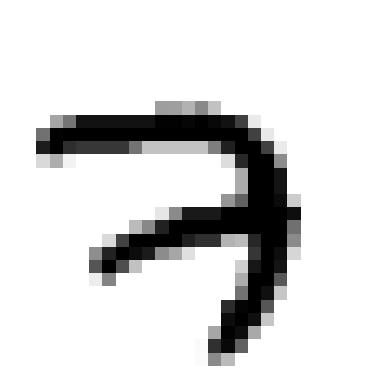

In [525]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [526]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [527]:
X_valid.shape

(5000, 28, 28)

In [528]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

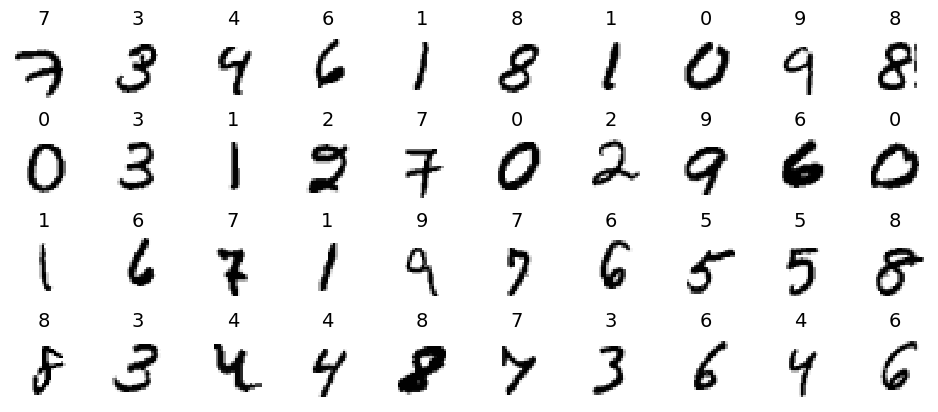

In [529]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [554]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [555]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [556]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/opt/anaconda3/envs/Alex_venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [557]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)
print(expon_lr)

Now let's train the model for just 1 epoch:

In [558]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

AttributeError: 'str' object has no attribute 'name'

We can now plot the loss as a functionof the learning rate:

/var/folders/p0/l0f81wr95lqgtrh7g618gzbw0000gn/T/ipykernel_17250/2891158959.py:4: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])


Text(0, 0.5, 'Loss')

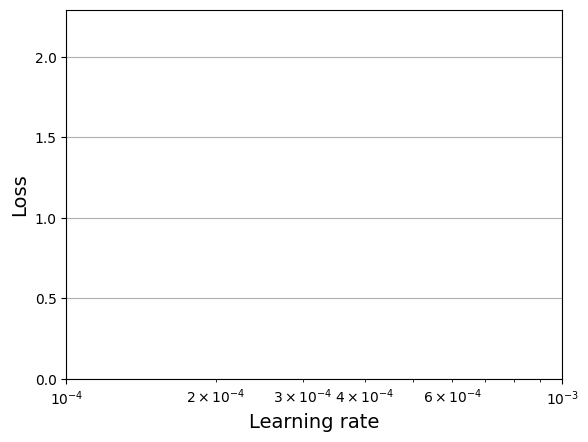

In [559]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [560]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [561]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [562]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [563]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [564]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=my_mnist_model

In [565]:
model = tf.keras.models.load_model("my_mnist_model") # rollback to best model
model.evaluate(X_test, y_test)

ValueError: File format not supported: filepath=my_mnist_model. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(my_mnist_model, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [566]:
%tensorboard --logdir=./my_mnist_logs